*Created by Will Dinneen (willdinneen@gmail.com) for the PDRI-DevLab Junior Data Scientist Position @ UPenn*

## Introduction

- Here I will write my overall methodology and considerations, as well as a summary of key results
- Make sure to write it like a study (including with a hypothesis, etc...)
    - Be rigorous about your causality & assumptions thought process. They care less about the right answer than about how you are thinking about it!

- Your work doesn't end with the model, but also with interpreting the results
- Remember what P-Values are and what your regression is actually saying: you are rejecting or failing to reject the null hypothesis that the treatment has no effect on re-arrest

## Data Management

In [263]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import copy

# Datasets
case_df = pd.read_csv('../case.csv')
demo_df = pd.read_csv('../demo.csv')
prior_arrests_df = pd.read_csv('../prior_arrests.csv')
grades_df = pd.read_csv('../grades.csv')

In [228]:
# 1. Recode it so that males are consistently coded as “M” and females are consistently coded as “F”.

print("Gender column values pre-recode:")
print(demo_df["gender"].unique())

# Gender column recoding
gender_recode = {
    'male': 'M',
    'female': 'F'
}

demo_df["gender"] = demo_df["gender"].replace(gender_recode)

print("\nGender column values post-recode:")
print(demo_df["gender"].unique())

Gender column values pre-recode:
['F' 'M' 'male' 'female']

Gender column values post-recode:
['F' 'M']


In [229]:
# 2. Merge the case and demo datasets together so that each row in the case dataset also contains the demographics of the defendant.

# Confirm Data Integrity
print("---- Checking Data Integrity ----\n")

missing_demo_values = demo_df["person_id"].isnull().sum()
missing_case_values = case_df["person_id"].isnull().sum()
print(f"Missing demographic values: {missing_demo_values}")
print(f"Missing case values: {missing_case_values}")

duplicate_demo_ids = demo_df["person_id"].duplicated().sum()
print(f"\nDuplicate demographic ids: {duplicate_demo_ids}")
# Check to see if duplicated IDs are duplicated rows
duplicate_ids = demo_df[demo_df["person_id"].duplicated(keep=False)]
duplicated_rows = duplicate_ids[duplicate_ids.duplicated(keep=False)]
print(f"Number of contradictory demographic ids: {len(duplicate_ids) - len(duplicated_rows)}")

# Dropping duplicates
demo_df = demo_df.drop_duplicates()

# Measure Differences Accross Demo & Case data
print("\n\n---- Comparing Demographic & Case Representation ----\n")

unique_case_ids = case_df["person_id"].unique()
unique_demo_ids = demo_df["person_id"].unique()
print("Number of unique persons in case data:")
print(len(unique_case_ids))

print("\nNumber of unique persons in demographic data:")
print(len(unique_demo_ids))

print("\nDifference in number of unique persons in demographic vs case data:")
print(len(unique_demo_ids) - len(unique_case_ids))

# Identify extra demo IDs & save to file for later investigation 
extra_demo_ids = set(unique_demo_ids) - set(unique_case_ids)
extra_demo_ids_df = pd.DataFrame(extra_demo_ids, columns=['person_id'])
extra_demo_ids_df.to_csv('./outputs/extra_demo_ids.csv', index=False)

# Merge the df
merged_df = case_df.merge(demo_df, on='person_id', how='left')

# Check for missing values
print(f"\nMissing values after merge:\n{merged_df.isnull().sum()}")

---- Checking Data Integrity ----

Missing demographic values: 0
Missing case values: 0

Duplicate demographic ids: 4721
Number of contradictory demographic ids: 0


---- Comparing Demographic & Case Representation ----

Number of unique persons in case data:
15353

Number of unique persons in demographic data:
15715

Difference in number of unique persons in demographic vs case data:
362

Missing values after merge:
caseid           0
person_id        0
arrest_date      0
dispos_date      0
treat            0
re_arrest        0
prior_arrests    0
address          0
race             0
gender           0
bdate            0
dtype: int64


In [230]:
# 3. For the purpose of this analysis, please restrict the data to only individuals who were arrested in Chicago.

# Check the format of the address column
address_format_check = merged_df["address"].str.contains(", ")
print(f"Number of addresses with correct format: {address_format_check.sum()}")
print(f"Number of addresses with incorrect format: {(~address_format_check).sum()}")

# Extract the city from the address column
merged_df["city"] = merged_df["address"].str.split(", ").str[1]

# Confirm that all cities are the same case
merged_df["city"] = merged_df["city"].str.lower()

# Check to see if there are any misspelled values
print(f"\nRepresented cities: {merged_df['city'].unique()}")

# Extract all rows with arrests in Chicago
chicago_df = merged_df[merged_df["city"] == "chicago"].copy()

print(f"\nNumber of cases in Chicago: {len(chicago_df)}")

Number of addresses with correct format: 26000
Number of addresses with incorrect format: 0

Represented cities: ['chicago' 'oak lawn' 'cicero']

Number of cases in Chicago: 25000


## Variable Creation

In [231]:
# 1. Create an age variable equal to the defendant’s age at the time of arrest for each case.

# Validate bdate & arrest date format
chicago_df['bdate'] = pd.to_datetime(chicago_df['bdate'], errors='coerce')
if chicago_df['bdate'].isnull().sum() > 0:
    print("Some birth dates have an incorrect format.")
else:
    print("All birth dates have the correct format.")
    
chicago_df['arrest_date'] = pd.to_datetime(chicago_df['arrest_date'], errors='coerce')
if chicago_df['arrest_date'].isnull().sum() > 0:
    print("Some arrest dates have an incorrect format.")
else:
    print("All arrest dates have the correct format.")

# Create age variable
chicago_df['age'] = np.floor((chicago_df['arrest_date'] - chicago_df['bdate']) / pd.Timedelta(days=365.25))

All birth dates have the correct format.
All arrest dates have the correct format.


In [232]:
# 2. Please construct measures for 9th and 10th grade GPA for this target population.
grades_df

# Create the numeric grade scale
grade_scale_index = {
    "A": 4,
    "B": 3,
    "C": 2,
    "D": 1,
    "F": 0
}
grades_df = grades_df.replace(grade_scale_index)

# Create gr9 and gr10 GPA measures
def calculate_gpa(df, grade_level):
    relevant_columns = df.filter(like=grade_level)
    gpa_column = relevant_columns.mean(axis=1, skipna=True).round(3)
    return gpa_column
grades_df['gr9_gpa'] = calculate_gpa(grades_df, 'gr9')
grades_df['gr10_gpa'] = calculate_gpa(grades_df, 'gr10')

chicago_df

# Validate grades data
print("---- Validating Grades Data ----\n")
missing_grades_ids = grades_df['person_id'].isnull().sum()
print(f"Number of missing IDs in grade data: {missing_grades_ids}")
duplicate_grades_ids = grades_df["person_id"].duplicated().sum()
print(f"Duplicate grades ids: {duplicate_grades_ids}")

# Check if all relevant ids exist in both datasets
filtered_chicago_df = chicago_df[(chicago_df['age'] >= 18) & (chicago_df['age'] <= 24)]
relevant_chicago_ids = set(filtered_chicago_df['person_id'])
grade_ids = set(grades_df['person_id'])
missing_grades_ids = relevant_chicago_ids - grade_ids
print(f"\nNumber of relevant IDs in Chicago data not represented in Grade data: {len(missing_grades_ids)}")
missing_grades_data_ids = pd.DataFrame(missing_grades_ids, columns=['person_id'])
missing_grades_data_ids.to_csv('./outputs/missing_grades_data_ids.csv', index=False)
print("Missing grades data IDs saved to file: ./outputs/missing_grades_data_ids.csv")

# Add GPA measures to chicago_df
filtered_chicago_df = pd.merge(filtered_chicago_df, grades_df[['person_id', 'gr9_gpa', 'gr10_gpa']], on='person_id', how='left')
chicago_df = pd.merge(chicago_df, filtered_chicago_df[['caseid', 'gr9_gpa', 'gr10_gpa']], on='caseid', how='left')

---- Validating Grades Data ----

Number of missing IDs in grade data: 0
Duplicate grades ids: 0

Number of relevant IDs in Chicago data not represented in Grade data: 3006
Missing grades data IDs saved to file: ./outputs/missing_grades_data_ids.csv


In [233]:
# 3.a. Please reconstruct the variable (prior arrests) using the prior_arrests.csv file. 

# Validate prior arrests data
print("---- Validating Prior Arrests Data ----\n")
missing_arrest_ids = prior_arrests_df['person_id'].isnull().sum()
print(f"Number of missing IDs in prior arrests data: {missing_arrest_ids}")

# Validate date format
prior_arrests_df['arrest_date'] = pd.to_datetime(prior_arrests_df['arrest_date'], errors='coerce')
if prior_arrests_df['arrest_date'].isnull().sum() > 0:
    print("\nSome arrest dates have an incorrect format.")
else:
    print("All arrest dates have the correct format.")
    
# Confirm that there is no overlap so as not to double count
print(f"\nMost recent prior_arrest_df date: {prior_arrests_df['arrest_date'].max()}")
print(f"Oldest chicago_df date: {chicago_df['arrest_date'].min()}")

# Check if all arrest ids exist in both datasets
prior_arrests_ids = set(prior_arrests_df['person_id'])
chicago_ids = set(chicago_df['person_id'])
if prior_arrests_ids.issubset(chicago_ids):
    print("\nAll person IDs from prior_arrests_df exist in chicago_df")
else:
    print("\nNot all person IDs from prior_arrests_df exist in chicago_df")

# Reconstruct prior_arrests variable
prior_arrest_counts = prior_arrests_df.groupby('person_id').size().reset_index(name='reconstructed_prior_arrests')
chicago_df = pd.merge(chicago_df, prior_arrest_counts, on='person_id', how='left')
chicago_df['reconstructed_prior_arrests'] = chicago_df['reconstructed_prior_arrests'].fillna(0)
chicago_df['reconstructed_prior_arrests'] = chicago_df['reconstructed_prior_arrests'].astype(int)

# Add arrests that occured during the study period
chicago_df_sorted = chicago_df.sort_values(['person_id', 'arrest_date'])
chicago_df_sorted['reconstructed_prior_arrests'] = chicago_df_sorted.groupby('person_id').cumcount() + chicago_df_sorted['reconstructed_prior_arrests']
chicago_df.loc[chicago_df_sorted.index, 'reconstructed_prior_arrests'] = chicago_df_sorted['reconstructed_prior_arrests']

# 3.b. Please reconstruct this indicator (re_arrest).

# Calculate whether each row was rearrested
def calculate_re_arrests(row):
    other_cases = chicago_df_sorted[chicago_df_sorted['person_id'] == row['person_id']]
    subsequent_cases = other_cases[other_cases['arrest_date'] > row['arrest_date']]
    re_arrests = subsequent_cases[subsequent_cases['arrest_date'] < row['dispos_date']]
    return len(re_arrests) > 0

chicago_df_sorted['reconstructed_re_arrest'] = chicago_df_sorted.apply(calculate_re_arrests, axis=1)
chicago_df_sorted['reconstructed_re_arrest'] = chicago_df_sorted['reconstructed_re_arrest'].astype(int)

chicago_df.loc[chicago_df_sorted.index, 'reconstructed_re_arrest'] = chicago_df_sorted['reconstructed_re_arrest']

# 3.c. Please show that the variables you reconstructed are equal to the versions in the provided datasets.

print("\n\n---- Validating Reconstructed Variables ----\n")

# Check prior_arrests variable
prior_arrests_differences = chicago_df[chicago_df['prior_arrests'] != chicago_df['reconstructed_prior_arrests']]
print(f"Number of differenes between prior_arrests & reconstructed_prior_arrests: {len(prior_arrests_differences)}")

# Check re_arrest variable
re_arrest_differences = chicago_df[chicago_df['re_arrest'] != chicago_df['reconstructed_re_arrest']]
print(f"Number of differenes between re_arrest & reconstructed_re_arrest: {len(re_arrest_differences)}")

---- Validating Prior Arrests Data ----

Number of missing IDs in prior arrests data: 0
All arrest dates have the correct format.

Most recent prior_arrest_df date: 2011-12-31 00:00:00
Oldest chicago_df date: 2012-01-02 00:00:00

All person IDs from prior_arrests_df exist in chicago_df


---- Validating Reconstructed Variables ----

Number of differenes between prior_arrests & reconstructed_prior_arrests: 0
Number of differenes between re_arrest & reconstructed_re_arrest: 0


## Statistical Analysis

---- Describing Demographics ----


Age: 
+-------+-------------+
|       |         age |
|-------+-------------|
| count | 25000       |
| mean  |    29.8221  |
| std   |     7.79954 |
| min   |     9       |
| 25%   |    24       |
| 50%   |    29       |
| 75%   |    35       |
| max   |    70       |
+-------+-------------+


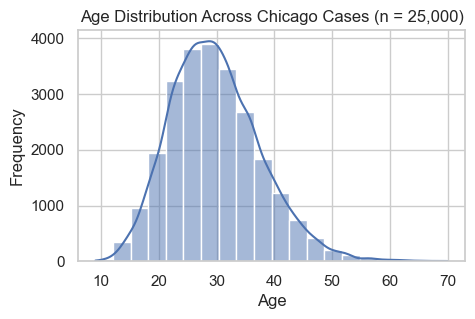


Gender Counts: 
+----+----------+
|    |   gender |
|----+----------|
| M  |    20064 |
| F  |     4936 |
+----+----------+

Gender Percentage: 
+----+----------+
|    |   gender |
|----+----------|
| M  |   80.256 |
| F  |   19.744 |
+----+----------+

Race Counts: 
+-------+--------+
|       |   race |
|-------+--------|
| BLACK |  18249 |
| WHITE |   5512 |
| ASIAN |   1239 |
+-------+--------+

Race Percentage: 
+-------+--------+
|       |   race |
|-------+--------|
| BLACK | 72.996 |
| WHITE | 22.048 |
| ASIAN |  4.956 |
+-------+--------+


In [234]:
# 1. Describe the demographic characteristics of the study population based on the data available to you.

print("---- Describing Demographics ----\n")

# Summary statistics
print("\nAge: ")
print(chicago_df['age'].describe().to_markdown(tablefmt="psql"))

# Age Histogram
plt.figure(figsize=(5,3))
sns.histplot(data=chicago_df, x="age", bins=20, kde=True)
plt.title("Age Distribution Across Chicago Cases (n = 25,000)")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

print("\nGender Counts: ")
gender_counts = chicago_df['gender'].value_counts()
print(gender_counts.to_markdown(tablefmt="psql"))
print("\nGender Percentage: ")
gender_percentages = chicago_df['gender'].value_counts(normalize=True) * 100
print(gender_percentages.to_markdown(tablefmt="psql"))

print("\nRace Counts: ")
race_counts = chicago_df['race'].value_counts()
print(race_counts.to_markdown(tablefmt="psql"))
print("\nRace Percentage: ")
race_percentages = chicago_df['race'].value_counts(normalize=True) * 100
print(race_percentages.to_markdown(tablefmt="psql"))

**Balancing Methods**

Logistic Regression on Treatment as DV to see if Age, Race, or Gender have any unbalanced correlation with treatments.
- Race and Gender are totally balanced
- Age is slightly unbalanced with the treatment group being larger, but although statistically significant, the difference is small enough that it is not substantively significant

Also ran a logistic regression to see if multiple offenders were more likely to be give treatment (e.g. because they had more opportunities to be give treatment!)
- Indeed, there seems to be a non-significant effect of multiple offenders. Regardeless, this is still a viable confounder 

In [244]:
# 1.a. Are the treatment and control groups balanced?

import statsmodels.api as sm
import pandas as pd

# Encode Race & Gender
chicago_df['gender_binary'] = chicago_df['gender'].astype('category').cat.codes
race_dummies = pd.get_dummies(chicago_df['race'], prefix='race')

# Drop black column to avoid perfect colinearity 
race_dummies = race_dummies.drop('race_BLACK', axis=1)

X = pd.concat([chicago_df[['age', 'gender_binary']], race_dummies], axis=1)
X = sm.add_constant(X)

y = chicago_df['treat']

# Fit the model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

print("\n\nDescription of Age Across Groups:")
print(chicago_df.groupby('treat')['age'].describe().to_markdown(tablefmt="psql"))

Optimization terminated successfully.
         Current function value: 0.672005
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                25000
Model:                          Logit   Df Residuals:                    24995
Method:                           MLE   Df Model:                            4
Date:                Fri, 07 Jul 2023   Pseudo R-squ.:                 0.02861
Time:                        10:29:06   Log-Likelihood:                -16800.
converged:                       True   LL-Null:                       -17295.
Covariance Type:            nonrobust   LLR p-value:                6.151e-213
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.4731      0.059    -24.857      0.000      -1.589      -1.357
age               0.

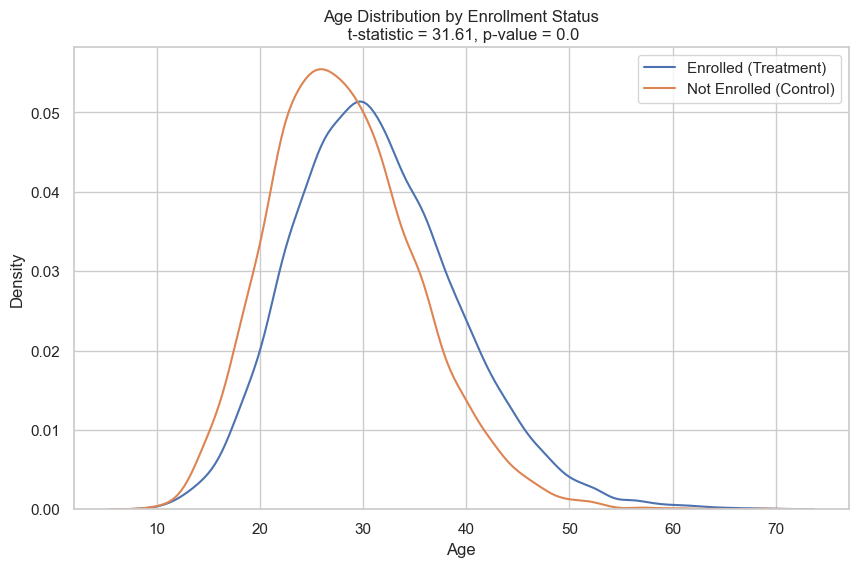

In [236]:
# 1.b. Choose one observable characteristic and visualize the difference between enrolled and not enrolled subjects.

treat_df = chicago_df[chicago_df['treat'] == 1]
control_df = chicago_df[chicago_df['treat'] == 0]

t_stat, p_val = stats.ttest_ind(treat_df['age'], control_df['age'])

# Plot
plt.figure(figsize=(10,6))
sns.kdeplot(treat_df['age'], label='Enrolled (Treatment)')
sns.kdeplot(control_df['age'], label='Not Enrolled (Control)')

plt.xlabel('Age')
plt.ylabel('Density')
plt.title(f'Age Distribution by Enrollment Status\n t-statistic = {t_stat.round(2)}, p-value = {p_val.round(3)}')
plt.legend()
plt.show()

In [239]:
chicago_df

,caseid,person_id,arrest_date,dispos_date,treat,re_arrest,prior_arrests,address,race,gender,bdate,city,age,gr9_gpa,gr10_gpa,reconstructed_prior_arrests,reconstructed_re_arrest,gender_binary
0,57514,1,2012-01-04,2012-03-27,0,0,2,"1698 W 25TH PL, CHICAGO",WHITE,F,1985-07-03,chicago,26.0,NaN,NaN,2,0,0
1,39970,1,2012-07-11,2012-10-20,1,0,3,"4866 S CORNELL AVE, CHICAGO",WHITE,F,1985-07-03,chicago,27.0,NaN,NaN,3,0,0
2,88413,1,2013-04-04,2013-06-22,0,0,4,"2543 N WILLETTS CT, CHICAGO",WHITE,F,1985-07-03,chicago,27.0,NaN,NaN,4,0,0
3,40216,5,2012-03-31,2013-03-25,0,0,2,"4578 W MORSE AVE, CHICAGO",BLACK,M,1986-09-27,chicago,25.0,NaN,NaN,2,0,1
4,92255,6,2012-12-09,2013-11-09,0,0,3,"5111 S SANGAMON ST, CHICAGO",BLACK,M,1991-06-07,chicago,21.0,NaN,NaN,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,14458,19995,2013-02-16,2013-03-18,1,0,2,"1470 W EISENHOWER ASHLAND AV ER, CHICAGO",BLACK,M,1986-07-02,chicago,26.0,NaN,NaN,2,0,1
24996,15597,19996,2012-05-04,2012-08-04,0,0,5,"748 W 87TH ST S, CHICAGO",BLACK,F,1978-10-31,chicago,33.0,NaN,NaN,5,0,0
24997,2230,19997,2012-09-15,2012-10-02,0,0,2,"116 W GERMANIA PL, CHICAGO",ASIAN,M,1986-03-14,chicago,26.0,NaN,NaN,2,0,1
24998,21029,19999,2013-08-17,2014-10-19,0,0,2,"3032 E 136TH ST, CHICAGO",BLACK,M,1989-02-13,chicago,24.0,NaN,NaN,2,0,1


In [257]:
# 3. Did participating in the program reduce the likelihood of re-arrest before disposition? Explain your answer and your methodology.

print("---- Describing Treatment & Outcomes ----\n")

cross_tab = pd.crosstab(chicago_df['treat'], chicago_df['re_arrest'])
cross_tab.columns = ['re_arrest_0', 're_arrest_1']

# print(cross_tab.to_markdown(tablefmt="psql", index=None))

print(cross_tab.to_markdown(tablefmt="psql"))

print("\n\n---- Running Regression ----\n")

# Create covariates
race_dummies = pd.get_dummies(chicago_df['race'], prefix='race')
race_dummies = race_dummies.drop('race_BLACK', axis=1)

chicago_df = pd.concat([chicago_df, race_dummies], axis=1)

# Run a Logit Regression
X = chicago_df[['treat', 'age', 'gender_binary', 'prior_arrests', 'race_ASIAN', 'race_WHITE']]

y = chicago_df['re_arrest']
X = sm.add_constant(X)

# Fit model
model = sm.Logit(y, X)
result = model.fit()

# Print the model summary
print(result.summary())

---- Describing Treatment & Outcomes ----

+---------+---------------+---------------+
|   treat |   re_arrest_0 |   re_arrest_1 |
|---------+---------------+---------------|
|       0 |          9459 |          2392 |
|       1 |         10288 |          2861 |
+---------+---------------+---------------+


---- Running Regression ----

Optimization terminated successfully.
         Current function value: 0.504746
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              re_arrest   No. Observations:                25000
Model:                          Logit   Df Residuals:                    24993
Method:                           MLE   Df Model:                            6
Date:                Fri, 07 Jul 2023   Pseudo R-squ.:                 0.01823
Time:                        10:53:22   Log-Likelihood:                -12619.
converged:                       True   LL-Null:                       -12853.
Covari

In [266]:
# 4. Using the data available to you, what recommendation would you make regarding who to serve?

# Check for interactions
interaction_df = chicago_df.copy()

for col in ['age', 'gender_binary', 'prior_arrests', 'race_ASIAN', 'race_WHITE']:
    interaction_df[f'treat_{col}'] = interaction_df['treat'] * interaction_df[col]

# Now we'll add these interaction terms into our regression model
X = interaction_df[['treat', 
                    'age', 
                    'treat_age',
                    'gender_binary',
                    'treat_gender_binary',
                    'prior_arrests', 
                    'treat_prior_arrests', 
                    'race_ASIAN', 
                    'treat_race_ASIAN',
                    'race_WHITE',
                    'treat_race_WHITE'
                   ]]

y = interaction_df['re_arrest']
X = sm.add_constant(X)

# Fit the model
model = sm.Logit(y, X)
result = model.fit()

# Print the summary
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.504372
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              re_arrest   No. Observations:                25000
Model:                          Logit   Df Residuals:                    24988
Method:                           MLE   Df Model:                           11
Date:                Fri, 07 Jul 2023   Pseudo R-squ.:                 0.01895
Time:                        10:58:49   Log-Likelihood:                -12609.
converged:                       True   LL-Null:                       -12853.
Covariance Type:            nonrobust   LLR p-value:                 1.733e-97
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.4545      0.110    -22.405      0.000      -2.669      -2.240
tr

In [267]:
# Examining the effect of treatment if we only look at the first offense

print("---- Describing Treatment & Outcomes ----\n")

chicago_df_first_offence = chicago_df.drop_duplicates(subset='person_id', keep='first')
cross_tab = pd.crosstab(chicago_df_first_offence['treat'], chicago_df_first_offence['re_arrest'])
cross_tab.columns = ['re_arrest_0', 're_arrest_1']

# print(cross_tab.to_markdown(tablefmt="psql", index=None))

print(cross_tab.to_markdown(tablefmt="psql"))

print("\n\n---- Running Regression ----\n")

# Run a Logit Regression

# X = chicago_df_first_offence['treat']
X = chicago_df_first_offence[['treat', 'age', 'gender_binary', 'prior_arrests', 'race_ASIAN', 'race_WHITE']]

y = chicago_df_first_offence['re_arrest']
X = sm.add_constant(X)

# Fit model
model = sm.Logit(y, X)
result = model.fit()

# Print the model summary
print(result.summary())

---- Describing Treatment & Outcomes ----

+---------+---------------+---------------+
|   treat |   re_arrest_0 |   re_arrest_1 |
|---------+---------------+---------------|
|       0 |          5973 |          1609 |
|       1 |          5058 |          1713 |
+---------+---------------+---------------+


---- Running Regression ----

Optimization terminated successfully.
         Current function value: 0.494843
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              re_arrest   No. Observations:                14353
Model:                          Logit   Df Residuals:                    14346
Method:                           MLE   Df Model:                            6
Date:                Fri, 07 Jul 2023   Pseudo R-squ.:                 0.08536
Time:                        11:03:13   Log-Likelihood:                -7102.5
converged:                       True   LL-Null:                       -7765.3
Covari

## Conclusion

## Appendix

In [158]:
# Checking to see if multiple offenders are more likely to receive treatment
chicago_df_by_person_id = chicago_df.groupby('person_id').agg({'treat': 'max', 
                                                                'prior_arrests': "max",
                                                                're_arrest': "max",
                                                                'race': "first",
                                                                'gender': "first",
                                                                'age': "first"
                                                              }).reset_index()
chicago_df_by_person_id['multiple_offence'] = chicago_df['person_id'].duplicated(keep=False).astype(int)

X = chicago_df_by_person_id['multiple_offence']
X = sm.add_constant(X)

y = chicago_df_by_person_id['treat']

# Fit the model
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.654386
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                14353
Model:                          Logit   Df Residuals:                    14351
Method:                           MLE   Df Model:                            1
Date:                Thu, 06 Jul 2023   Pseudo R-squ.:               9.871e-05
Time:                        22:44:39   Log-Likelihood:                -9392.4
converged:                       True   LL-Null:                       -9393.3
Covariance Type:            nonrobust   LLR p-value:                    0.1733
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.5308      0.032     16.571      0.000       0.468       0.594
multiple_of

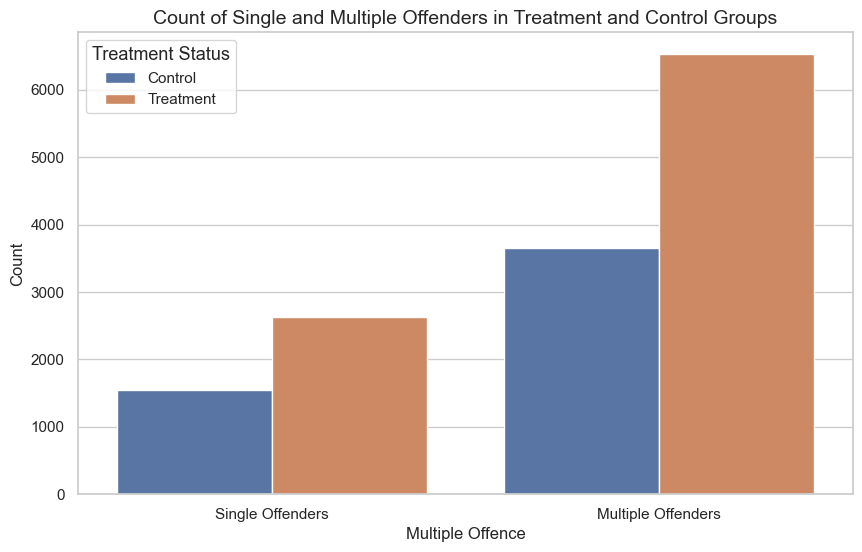

In [160]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
ax = sns.countplot(x="multiple_offence", hue="treat", data=chicago_df_by_person_id)

# Adding legends, titles and labels for clarity
ax.set_title('Count of Single and Multiple Offenders in Treatment and Control Groups', fontsize=14)
ax.set_xlabel('Multiple Offence', fontsize=12)
ax.set_xticklabels(['Single Offenders', 'Multiple Offenders'])
ax.set_ylabel('Count', fontsize=12)
plt.legend(title='Treatment Status', title_fontsize='13', labels=['Control', 'Treatment'])

plt.show()

In [256]:
# Running some robustness checks

print("---- Checking For Non-Linear Relationship in Age -----")

chicago_df["age_squared"] = chicago_df["age"] ** 2

# Run a Logit Regression
X = chicago_df[['treat', 'age', 'age_squared']]

y = chicago_df['re_arrest']
X = sm.add_constant(X)

# Fit model
model = sm.Logit(y, X)
result = model.fit()

# Print the model summary
print(result.summary())

---- Checking For Non-Linear Relationship in Age -----
Optimization terminated successfully.
         Current function value: 0.506494
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              re_arrest   No. Observations:                25000
Model:                          Logit   Df Residuals:                    24996
Method:                           MLE   Df Model:                            3
Date:                Fri, 07 Jul 2023   Pseudo R-squ.:                 0.01482
Time:                        10:47:03   Log-Likelihood:                -12662.
converged:                       True   LL-Null:                       -12853.
Covariance Type:            nonrobust   LLR p-value:                 2.789e-82
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.6589      0.182    -14.603      0